# Example code

# Step 1: Load and Preprocess Your Real Data

In [1]:
import numpy as np
import os

def load_eye_tracking_data(folder_path, file_extension='Waldo_Ruj1.txt', remove_first_n_points=250):
    files = [file for file in os.listdir(folder_path) if file.endswith(file_extension)]
    if not files:
        raise FileNotFoundError(f"No files found with extension '{file_extension}' in '{folder_path}'.")
    T, X, Y, saccade = [], [], [], []
    for file in files:
        file_path = os.path.join(folder_path, file)
        data = np.loadtxt(file_path)
        if data.shape[0] > data.shape[1]:
            data = data.T
        T_i = data[0][remove_first_n_points:]
        X_i = data[1][remove_first_n_points:]
        Y_i = data[2][remove_first_n_points:]
        saccade_i = data[3][remove_first_n_points:]
        T.append(T_i)
        X.append(X_i)
        Y.append(Y_i)
        saccade.append(saccade_i)
    return {"T": T, "X": X, "Y": Y, "saccade": saccade}

# Example usage:
folder_path = '/home/shailendra/Documents/PhD_Oslomet/QuantumGanWaldo/WALDO/WalDo'
real_data = load_eye_tracking_data(folder_path)


# Step 2: Calculate Empirical Moments


In [2]:
def calculate_real_moments(real_data, tau_list):
    dx2_log_list = []
    dx4_log_list = []
    for X, Y in zip(real_data['X'], real_data['Y']):
        X, Y = np.array(X), np.array(Y)
        valid_indices = np.isfinite(X) & np.isfinite(Y)
        X, Y = X[valid_indices], Y[valid_indices]
        if len(X) < max(tau_list) + 1:
            continue
        dx2 = []
        dx4 = []
        for tau in tau_list:
            dt = int(tau)
            if len(X) < dt + 1:
                break
            dx = X[dt:] - X[:-dt]
            dy = Y[dt:] - Y[:-dt]
            displacement = dx**2 + dy**2
            displacement = displacement[displacement > 0]
            if len(displacement) == 0:
                dx2.append(np.nan)
                dx4.append(np.nan)
                continue
            dx2.append(np.mean(displacement))
            dx4.append(np.mean(displacement**2))
        dx2 = np.array(dx2)
        dx4 = np.array(dx4)
        dx2_log = np.log(dx2[~np.isnan(dx2)])
        dx4_log = np.log(dx4[~np.isnan(dx4)])
        dx2_log_list.append(dx2_log)
        dx4_log_list.append(dx4_log)
    return {'log_M2': np.array(dx2_log_list), 'log_M4': np.array(dx4_log_list)}

tau_list = np.arange(1, 100)
real_moments = calculate_real_moments(real_data, tau_list)

# Calculate average moments
avg_real_m2 = np.nanmean(real_moments['log_M2'], axis=0)
avg_real_m4 = np.nanmean(real_moments['log_M4'], axis=0)


# Step 3: Fit the Intermittent Search and Lévy Walk Models

In [3]:
from intermittent_levy.optimization import to_optimize_mom4_and_2_serg_log
from intermittent_levy.moments import mom2_serg_log, mom4_serg_log
from scipy.optimize import differential_evolution
tau_list = np.arange(1, 100)
def fit_intermittent_model(tau_list, dx2_log, dx4_log):
    # Initial parameter estimates
    v0_est = 10
    D_est = 1
    lambda_B_est = 0.1
    lambda_D_est = 0.05
    # Define bounds
    bounds_IS = [
        (v0_est / 100, v0_est * 100),
        (D_est / 100, D_est * 100),
        (lambda_B_est / 100, lambda_B_est * 100),
        (lambda_D_est / 100, lambda_D_est * 100)
    ]
    args_IS = (tau_list, dx2_log, dx4_log)
    # Optimize
    result_IS = differential_evolution(
        to_optimize_mom4_and_2_serg_log,
        bounds=bounds_IS,
        args=args_IS,
        maxiter=1000,
        polish=True
    )
    optimized_params_IS = result_IS.x
    # Compute fitted moments
    fitted_mom2_IS = mom2_serg_log(tau_list, *optimized_params_IS)
    fitted_mom4_IS = mom4_serg_log(tau_list, *optimized_params_IS)
    return optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS

optimized_params_IS, fitted_mom2_IS, fitted_mom4_IS = fit_intermittent_model(tau_list, avg_real_m2, avg_real_m4)

from intermittent_levy.optimization import to_optimize_levy
from intermittent_levy.moments import levy_moments_log

def fit_levy_model(tau_list, dx2_log, dx4_log):
    alpha_est = 2.5
    v_mean_est = 10
    tmin_est = 0.01  # Adjust as necessary
    bounds_LW = [
        (1.1, 3.0),  # Alpha between 1.1 and 3
        (v_mean_est / 100, v_mean_est * 100)
    ]
    args_LW = (tau_list, dx2_log, dx4_log, tmin_est)
    result_LW = differential_evolution(
        to_optimize_levy,
        bounds=bounds_LW,
        args=args_LW,
        maxiter=1000,
        polish=True
    )
    optimized_alpha, optimized_v_mean = result_LW.x
    # Compute fitted moments
    fitted_mom2_LW = levy_moments_log(2, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    fitted_mom4_LW = levy_moments_log(4, optimized_alpha, optimized_v_mean, tau_list, tmin_est)
    return (optimized_alpha, optimized_v_mean, tmin_est), fitted_mom2_LW, fitted_mom4_LW

optimized_params_LW, fitted_mom2_LW, fitted_mom4_LW = fit_levy_model(tau_list, avg_real_m2, avg_real_m4)



# Step 4: Calculate Goodness-of-Fit Metrics


In [4]:
from intermittent_levy.utils import adjusted_r_square

# Adjusted R-squared for Intermittent Search Model
r2_mom2_IS = adjusted_r_square(avg_real_m2, fitted_mom2_IS, degrees_freedom=4)
r2_mom4_IS = adjusted_r_square(avg_real_m4, fitted_mom4_IS, degrees_freedom=4)
R2_adj_IS = (r2_mom2_IS + r2_mom4_IS) / 2

# Adjusted R-squared for Lévy Walk Model
r2_mom2_LW = adjusted_r_square(avg_real_m2, fitted_mom2_LW, degrees_freedom=3)
r2_mom4_LW = adjusted_r_square(avg_real_m4, fitted_mom4_LW, degrees_freedom=3)
R2_adj_LW = (r2_mom2_LW + r2_mom4_LW) / 2


# Step 5: Classify Each Trajectory


In [5]:
if R2_adj_IS > R2_adj_LW:
    print("Intermittent Search (IS) model fits the data better.")
    best_model = 'IS'
    best_params = optimized_params_IS
else:
    print("Lévy Walk (LW) model fits the data better.")
    best_model = 'LW'
    best_params = optimized_params_LW


Intermittent Search (IS) model fits the data better.


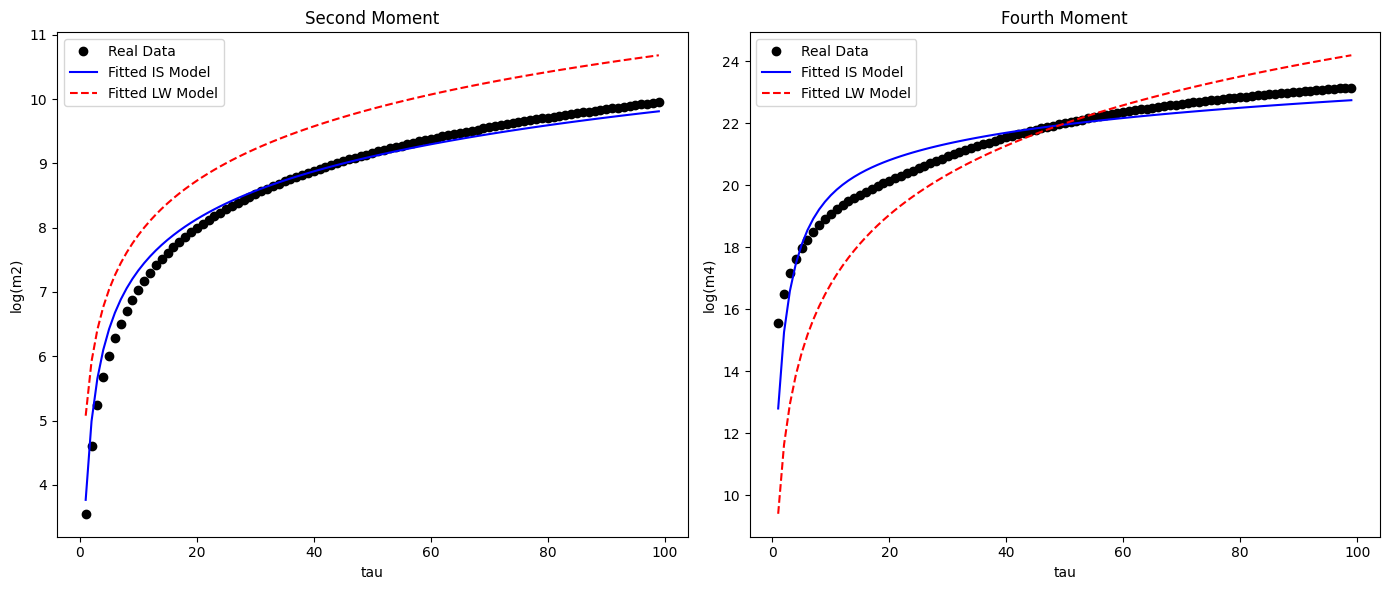

In [6]:
import matplotlib.pyplot as plt

# Ensure lengths match
min_length = min(len(avg_real_m2), len(fitted_mom2_IS), len(fitted_mom2_LW))
tau_list_plot = tau_list[:min_length]
avg_real_m2_plot = avg_real_m2[:min_length]
avg_real_m4_plot = avg_real_m4[:min_length]
fitted_mom2_IS = fitted_mom2_IS[:min_length]
fitted_mom4_IS = fitted_mom4_IS[:min_length]
fitted_mom2_LW = fitted_mom2_LW[:min_length]
fitted_mom4_LW = fitted_mom4_LW[:min_length]

# Plotting
plt.figure(figsize=(14, 6))

# Plotting M2
plt.subplot(1, 2, 1)
plt.plot(tau_list_plot, avg_real_m2_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, fitted_mom2_IS, '-', color='blue', label='Fitted IS Model')
plt.plot(tau_list_plot, fitted_mom2_LW, '--', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m2)')
plt.title('Second Moment')
plt.legend()

# Plotting M4
plt.subplot(1, 2, 2)
plt.plot(tau_list_plot, avg_real_m4_plot, 'o', color='black', label='Real Data')
plt.plot(tau_list_plot, fitted_mom4_IS, '-', color='blue', label='Fitted IS Model')
plt.plot(tau_list_plot, fitted_mom4_LW, '--', color='red', label='Fitted LW Model')
plt.xlabel('tau')
plt.ylabel('log(m4)')
plt.title('Fourth Moment')
plt.legend()

plt.tight_layout()
plt.show()


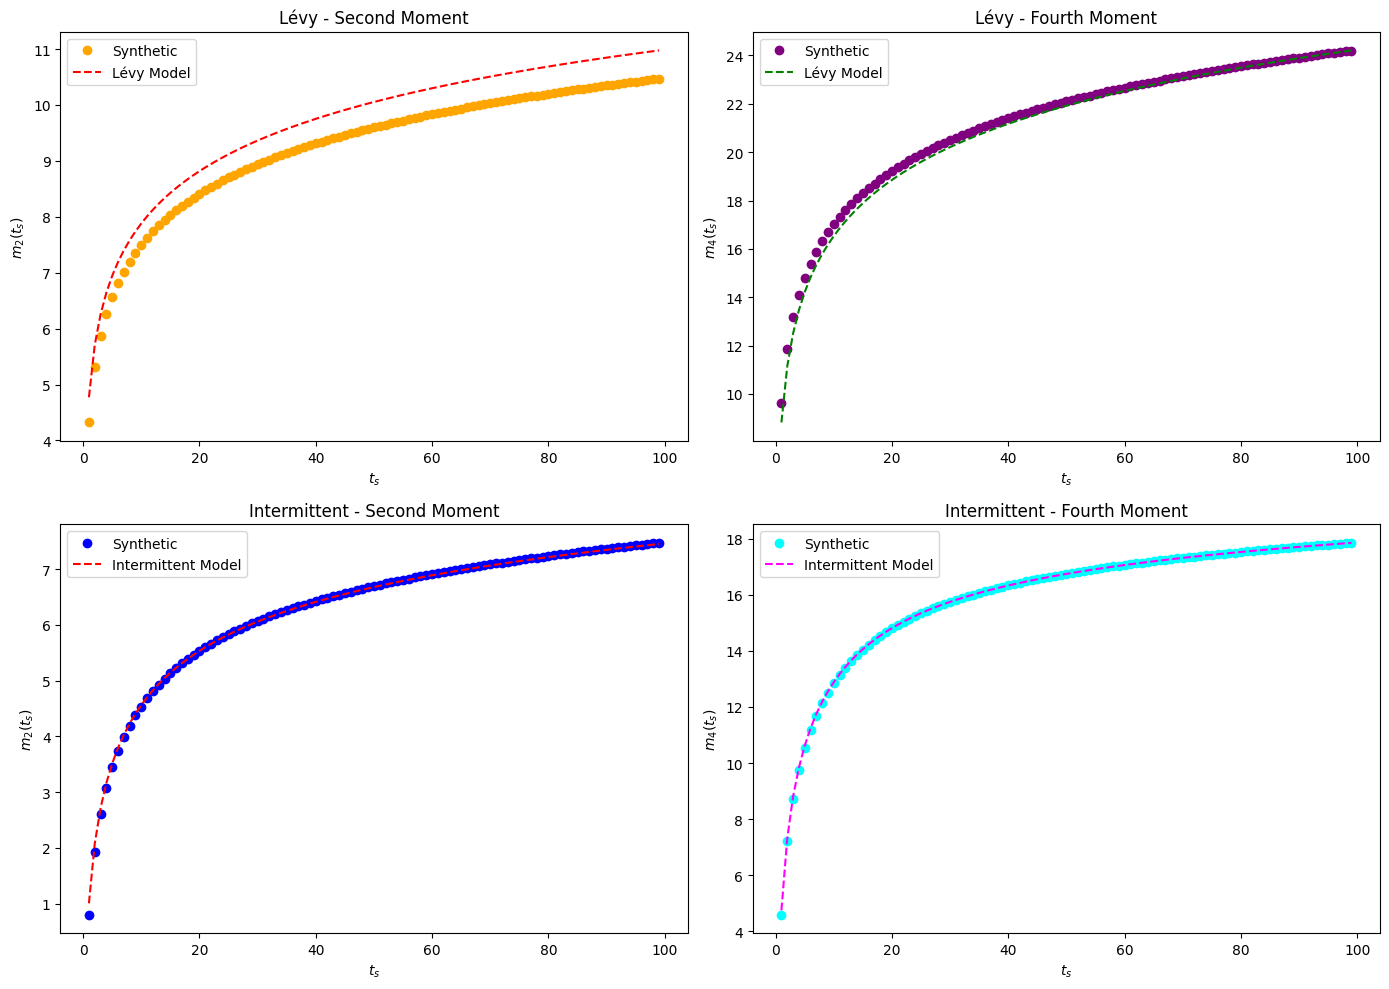

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved data
levy_m2 = np.loadtxt('results/levy/lev_generated_logdx2_list.txt')
levy_m4 = np.loadtxt('results/levy/lev_generated_logdx4_list.txt')
intermittent_m2 = np.loadtxt('results/intermittent/int_generated_logdx2_list.txt')
intermittent_m4 = np.loadtxt('results/intermittent/int_generated_logdx4_list.txt')

levy_fit_m2 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom2.txt')
levy_fit_m4 = np.loadtxt('results/levy/lev_generated_lev_fit_list_mom4.txt')
intermittent_fit_m2 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom2.txt')
intermittent_fit_m4 = np.loadtxt('results/intermittent/int_generated_int_fit_list_mom4.txt')

# Define tau_list (assuming the same tau_list is used for all simulations)
tau_list = np.arange(1, 100)

# Calculate the average over iterations
avg_levy_m2 = np.mean(levy_m2, axis=0)
avg_levy_m4 = np.mean(levy_m4, axis=0)
avg_intermittent_m2 = np.mean(intermittent_m2, axis=0)
avg_intermittent_m4 = np.mean(intermittent_m4, axis=0)

avg_levy_fit_m2 = np.mean(levy_fit_m2, axis=0)
avg_levy_fit_m4 = np.mean(levy_fit_m4, axis=0)
avg_intermittent_fit_m2 = np.mean(intermittent_fit_m2, axis=0)
avg_intermittent_fit_m4 = np.mean(intermittent_fit_m4, axis=0)

# Create the unified plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Lévy moments
axes[0, 0].plot(tau_list, avg_levy_m2, 'o', color='orange', label='Synthetic')
axes[0, 0].plot(tau_list, avg_levy_fit_m2, '--', color='red', label='Lévy Model')
axes[0, 0].set_title("Lévy - Second Moment")
axes[0, 0].set_xlabel('$t_s$')
axes[0, 0].set_ylabel('$m_2(t_s)$')
axes[0, 0].legend()

axes[0, 1].plot(tau_list, avg_levy_m4, 'o', color='purple', label='Synthetic')
axes[0, 1].plot(tau_list, avg_levy_fit_m4, '--', color='green', label='Lévy Model')
axes[0, 1].set_title("Lévy - Fourth Moment")
axes[0, 1].set_xlabel('$t_s$')
axes[0, 1].set_ylabel('$m_4(t_s)$')
axes[0, 1].legend()

# Plot Intermittent moments
axes[1, 0].plot(tau_list, avg_intermittent_m2, 'o', color='blue', label='Synthetic')
axes[1, 0].plot(tau_list, avg_intermittent_fit_m2, '--', color='red', label='Intermittent Model')
axes[1, 0].set_title("Intermittent - Second Moment")
axes[1, 0].set_xlabel('$t_s$')
axes[1, 0].set_ylabel('$m_2(t_s)$')
axes[1, 0].legend()

axes[1, 1].plot(tau_list, avg_intermittent_m4, 'o', color='cyan', label='Synthetic')
axes[1, 1].plot(tau_list, avg_intermittent_fit_m4, '--', color='magenta', label='Intermittent Model')
axes[1, 1].set_title("Intermittent - Fourth Moment")
axes[1, 1].set_xlabel('$t_s$')
axes[1, 1].set_ylabel('$m_4(t_s)$')
axes[1, 1].legend()

# Adjust layout and save the plot
plt.tight_layout()
plt.show()
